In [1]:
import os
import numpy as np
import pandas as pd
import glob as gb
import seaborn as sns
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

# import warnings
# warnings.filterwarnings("ignore")

2022-09-29 06:41:54.659247: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-29 06:41:54.659291: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Load the data

train_raw = loadmat('dataset/train_32x32.mat')
test_raw = loadmat('dataset/test_32x32.mat')

In [3]:
# Load images and labels

train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])

train_labels = train_raw['y']
test_labels = test_raw['y']

In [4]:
# Check the shape of the data

print(train_images.shape)
print(test_images.shape)
print(train_images.shape)
print(test_images.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)
(32, 32, 3, 73257)
(32, 32, 3, 26032)


In [5]:
# Fix the axes of the images

train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

print(train_images.shape)
print(test_images.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


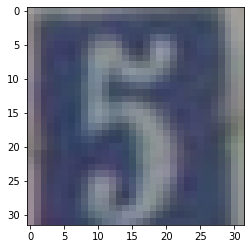

Label:  [5]


In [6]:
# Plot a random image and its label

plt.imshow(train_images[13529])
plt.show()

print('Label: ', train_labels[13529])

In [7]:
# Convert train and test images into 'float64' type

train_images = train_images.astype('float64')
test_images = test_images.astype('float64')

In [8]:
# Convert train and test labels into 'int64' type

train_labels = train_labels.astype('int64')
test_labels = test_labels.astype('int64')

In [9]:
# Normalize the images data

print('Min: {}, Max: {}'.format(train_images.min(), train_images.max()))

train_images /= 255.0
test_images /= 255.0

Min: 0.0, Max: 255.0


In [10]:
# One-hot encoding of train and test labels

lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

In [11]:
# Split train data into train and validation sets

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels,
                                                  test_size=0.15, random_state=22)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(62268, 32, 32, 3)
(62268, 10)
(10989, 32, 32, 3)
(10989, 10)


In [13]:
model = tf.keras.applications.MobileNetV2(input_shape=(32 , 32, 3),
                                           include_top=False,
                                           weights='imagenet')

top_model = model.output
top_model = Layers.Flatten()(top_model)
top_model = Layers.Dense(512, activation='relu')(top_model)
top_model = Layers.Dropout(0.5)(top_model)
top_model = Layers.Dense(64, activation='relu')(top_model)
top_model = Layers.Dropout(0.2)(top_model)

output_layer = Layers.Dense(10, activation='softmax')(top_model)
model = Models.Model(inputs=model.input, outputs=output_layer)
model = Models.Model(inputs=model.input, outputs=output_layer)

2022-09-29 06:42:01.456786: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-29 06:42:01.459535: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-29 06:42:01.459579: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (addin-gurihmas-dev): /proc/driver/nvidia/version does not exist
2022-09-29 06:42:01.459918: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
model.compile(optimizer=Optimizer.Adam(0.00001),loss='categorical_crossentropy' ,metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 16, 16, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 16, 16, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 16, 16, 32)   0           ['bn_Conv1[0][0]']               
                                                                                            

In [15]:
X_train.shape

(62268, 32, 32, 3)

In [16]:
y_train.shape

(62268, 10)

In [17]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5,verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
trained = model.fit(X_train,y_train,validation_split=0.3,epochs=100,callbacks=[reduce_lr,es],batch_size=32)

Epoch 1/100
1363/1363 [==============================] - 239s 171ms/step - loss: 2.6567 - accuracy: 0.1241 - val_loss: 2.2985 - val_accuracy: 0.1904 - lr: 1.0000e-05
Epoch 2/100
1363/1363 [==============================] - 230s 169ms/step - loss: 2.3628 - accuracy: 0.1531 - val_loss: 2.2835 - val_accuracy: 0.1904 - lr: 1.0000e-05
Epoch 3/100
1363/1363 [==============================] - 230s 169ms/step - loss: 2.2812 - accuracy: 0.1776 - val_loss: 2.2446 - val_accuracy: 0.2133 - lr: 1.0000e-05
Epoch 4/100
1363/1363 [==============================] - 230s 169ms/step - loss: 2.2341 - accuracy: 0.1956 - val_loss: 2.2011 - val_accuracy: 0.2315 - lr: 1.0000e-05
Epoch 5/100
1363/1363 [==============================] - 230s 169ms/step - loss: 2.1955 - accuracy: 0.2123 - val_loss: 2.1631 - val_accuracy: 0.2448 - lr: 1.0000e-05
Epoch 6/100
1363/1363 [==============================] - 230s 168ms/step - loss: 2.1570 - accuracy: 0.2278 - val_loss: 2.1304 - val_accuracy: 0.2604 - lr: 1.0000e-05
Epoc

In [18]:
# Evaluate train and validation accuracies and losses

train_acc = trained.history['accuracy']
val_acc = trained.history['val_accuracy']

train_loss = trained.history['loss']
val_loss = trained.history['val_loss']

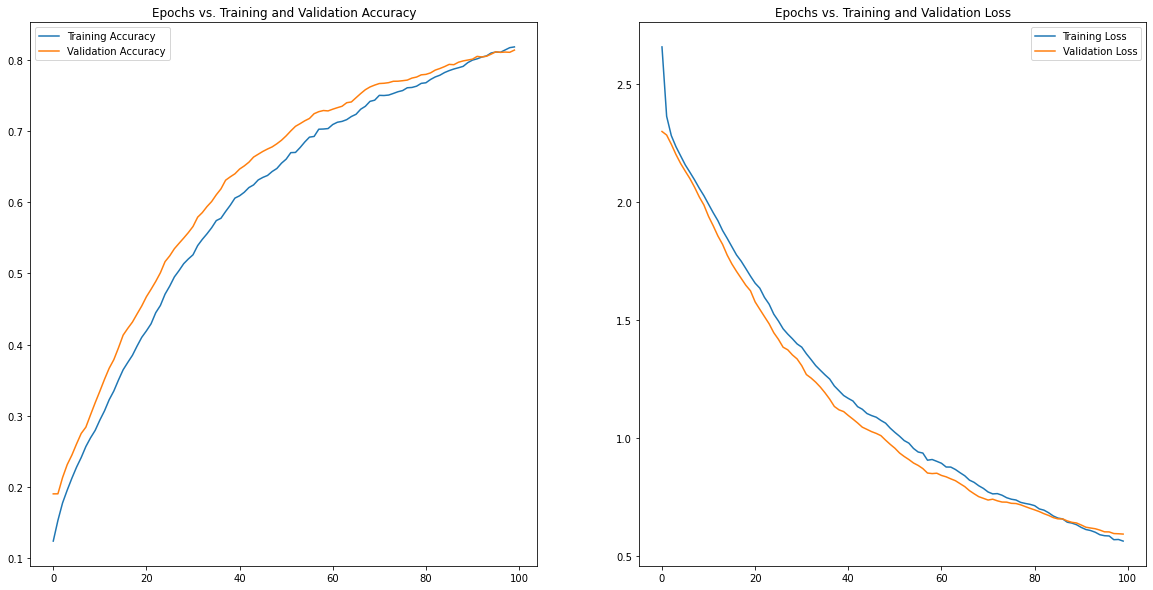

In [19]:
# Visualize epochs vs. train and validation accuracies and losses

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

In [20]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(x=test_images, y=test_labels, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.8138 
Test loss is: 0.5979


In [21]:
# Get predictions and apply inverse transformation to the labels

y_pred = model.predict(X_train)

y_pred = lb.inverse_transform(y_pred, lb.classes_)
y_train = lb.inverse_transform(y_train, lb.classes_)

2022-09-29 13:24:23.028608: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 765149184 exceeds 10% of free system memory.


1946/1946 [==============================] - 46s 23ms/step


In [23]:
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
classes = ["Number " + str(i) for i in range(10)]
print(classification_report(y_pred, y_train, target_names = classes))

              precision    recall  f1-score   support

    Number 0       0.94      0.90      0.92     12230
    Number 1       0.92      0.93      0.92      8920
    Number 2       0.79      0.78      0.79      7394
    Number 3       0.92      0.87      0.89      6634
    Number 4       0.83      0.82      0.82      5906
    Number 5       0.78      0.84      0.81      4570
    Number 6       0.88      0.91      0.90      4606
    Number 7       0.76      0.80      0.78      4105
    Number 8       0.79      0.87      0.83      3611
    Number 9       0.91      0.88      0.89      4292

    accuracy                           0.87     62268
   macro avg       0.85      0.86      0.86     62268
weighted avg       0.87      0.87      0.87     62268



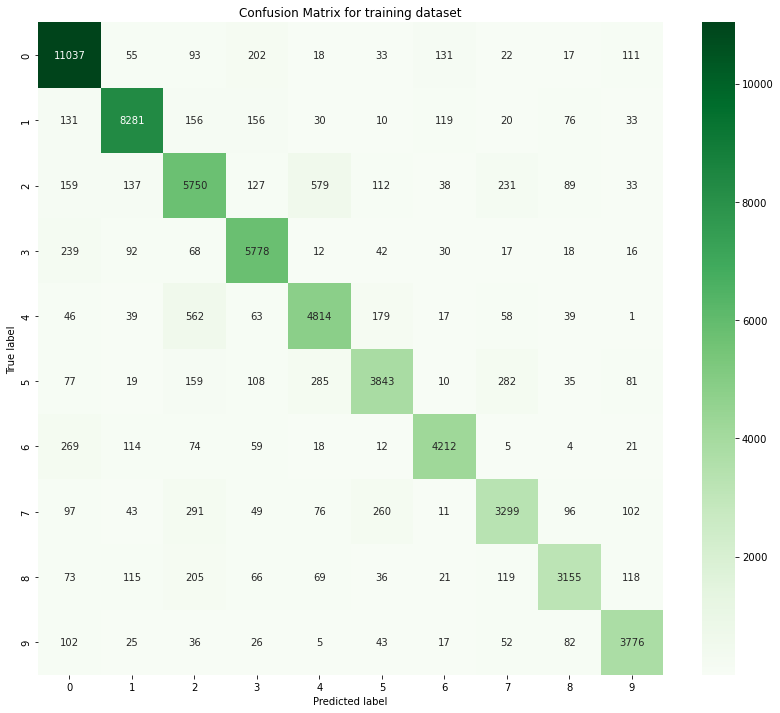

In [24]:
# Plot the confusion matrix

matrix = confusion_matrix(y_train, y_pred, labels=lb.classes_)

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [25]:
model.save("SVHN_MobileNetV2.h5")

In [26]:
y_pred = model.predict(test_images)
y_pred = lb.inverse_transform(y_pred, lb.classes_)
y_train = lb.inverse_transform(test_labels, lb.classes_)
classes = ["Number " + str(i) for i in range(10)]

814/814 [==============================] - 19s 23ms/step


In [27]:
print(classification_report(y_pred, y_train, target_names=classes))

              precision    recall  f1-score   support

    Number 0       0.90      0.89      0.90      5137
    Number 1       0.87      0.90      0.88      4016
    Number 2       0.75      0.70      0.72      3083
    Number 3       0.87      0.81      0.84      2707
    Number 4       0.77      0.77      0.77      2381
    Number 5       0.72      0.76      0.74      1886
    Number 6       0.82      0.86      0.84      1935
    Number 7       0.60      0.73      0.66      1368
    Number 8       0.78      0.72      0.75      1715
    Number 9       0.85      0.82      0.84      1804

    accuracy                           0.81     26032
   macro avg       0.79      0.80      0.79     26032
weighted avg       0.82      0.81      0.81     26032



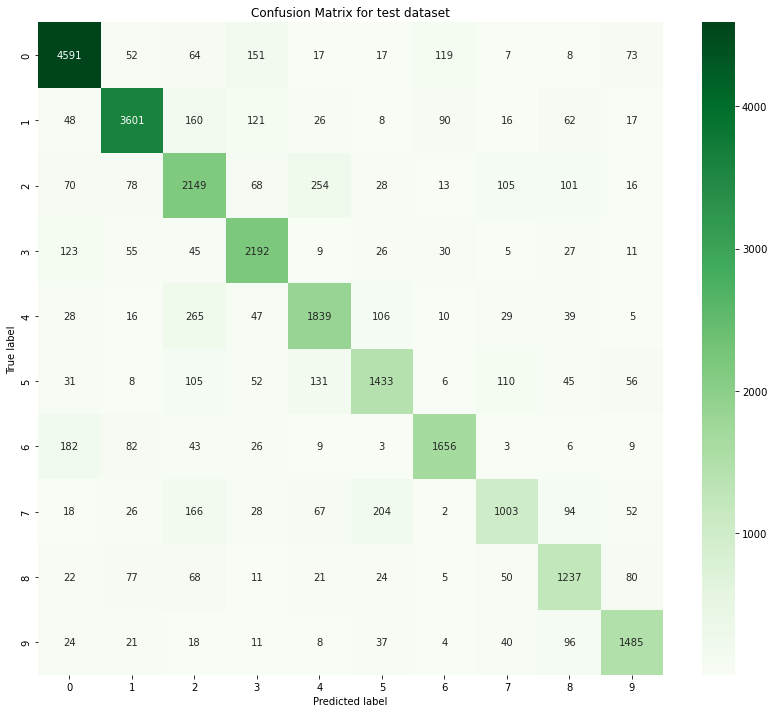

In [29]:
# Plot the confusion matrix

matrix = confusion_matrix(y_train, y_pred, labels=lb.classes_)

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for test dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()